# Project 3: Web APIs and NLP

# Problem Statement

Reddit is a huge collection of online discussions and forums of varying topics and subjects, that forms into communities over time. However, the vast number of subreddits can be overwhelming for new users, especially when there can be multiple subreddits that have similar discussion topics. 

The objective of this project is to produce a model which can accurately classify which subreddit a specific post belongs to, from the two subreddits- r/Netflix and r/AmazonPrimeVideo. Given that both of these involve discussions regarding the respective video streaming platforms, it would be a good test to see if the model can accurately classify posts from similar subreddits.

The results can be utilised by users who are unsure which subreddit their new post would be the most appropriate for, so that they can attract more engagement and minimise post removal from the subreddit moderators.

## Table of Contents

1. [Data Collection](#Data-Collection)
2. [Data Cleaning](#Data-cleaning)
3. [EDA](#EDA)
4. [Preprocessing & Modeling](#Preprocessing-&-Modeling)
5. [Model Evaluation](#Model-Evaluation)
6. [Conclusions & Recommendations](#Conclusions-&-Recommendations) 

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Data Collection

In [2]:
def load_from_url(url,params,total_num):
  not_reach_total_num = True
  res_list = []
  current_num = 0
  while not_reach_total_num:
    res = requests.get(url,params)
    params['before'] = res.json()['data'][-1]['created_utc']
    res = pd.DataFrame(res.json()['data'])
    res_list.append(res)
    current_num = current_num + len(res)
    if current_num >= total_num:
      not_reach_total_num = False
  res = pd.concat(res_list)
  return res

In [3]:
url = 'https://api.pushshift.io/reddit/search/submission/'
nflx_params = {
    'subreddit':'netflix',
    'size':100,
    'before':'1623149225'
}

In [4]:
netflix = load_from_url(url, nflx_params, 1000)

In [5]:
netflix.head()

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_patreon_flair,author_premium,...,gallery_data,is_gallery,media_metadata,author_flair_background_color,author_flair_text_color,banned_by,link_flair_css_class,link_flair_text,author_cakeday,edited
0,[],False,DarthVeX,None,[],None,text,t2_d8b0q,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],False,Background_Wafer6261,None,[],None,text,t2_climxyxl,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[],False,_PRATHISH_,None,[],None,text,t2_agvx991a,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[],False,aussiegolem,None,[],None,text,t2_167ggv8y,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[],False,haarunatplay,None,[],None,text,t2_8bvygabg,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
netflix = netflix[['subreddit', 'selftext', 'title', 'created_utc']]

In [7]:
netflix.head()

,subreddit,selftext,title,created_utc
0,netflix,I really hope we see more of this show. The t...,Sweet Tooth,1623145474
1,netflix,[removed],What Happened To Lenny Sander,1623143425
2,netflix,,Money Heist Season 5 Date Announcement - Keybo...,1623141210
3,netflix,I regularly argue with Netflix (the tv) when i...,What’s number 1 on Netflix in your country?,1623139632
4,netflix,[removed],When do the CW DC shows expire from Netflix?,1623136404


In [8]:
netflix.reset_index(drop = True, inplace = True)

In [9]:
netflix

,subreddit,selftext,title,created_utc
0,netflix,I really hope we see more of this show. The t...,Sweet Tooth,1623145474
1,netflix,[removed],What Happened To Lenny Sander,1623143425
2,netflix,,Money Heist Season 5 Date Announcement - Keybo...,1623141210
3,netflix,I regularly argue with Netflix (the tv) when i...,What’s number 1 on Netflix in your country?,1623139632
4,netflix,[removed],When do the CW DC shows expire from Netflix?,1623136404
...,...,...,...,...
995,netflix,[removed],Why is Army of the Dead only available in 1080p?,1621674021
996,netflix,[removed],Zack Snyder made a better zombie movie in 2004,1621673771
997,netflix,I’m trying to find a trailer for what I think ...,Help me find a film,1621673382
998,netflix,[removed],Is there anything particularly good I should w...,1621672056


In [10]:
amzn_params = {
    'subreddit':'AmazonPrimeVideo',
    'size':100,
    'before':'1623149225'
}

In [11]:
amazon = load_from_url(url, amzn_params, 1000)

In [12]:
amazon.head()

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_patreon_flair,author_premium,...,author_flair_text_color,banned_by,event_end,event_is_live,event_start,edited,crosspost_parent,crosspost_parent_list,distinguished,author_cakeday
0,[],False,Say_Echelon,None,[],None,text,t2_ckhlep3j,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],False,cwukitty,None,[],None,text,t2_4506sbqd,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[],False,ei283,None,[],None,text,t2_3jym0jz8,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[],False,ei283,None,[],None,text,t2_3jym0jz8,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[],False,chrismireya,None,[],None,text,t2_y8lda,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
amazon = amazon[['subreddit', 'selftext', 'title', 'created_utc']]

In [14]:
amazon.reset_index(drop = True, inplace = True)

In [15]:
amazon

,subreddit,selftext,title,created_utc
0,AmazonPrimeVideo,[removed],Debate: Invincible or The Boys?,1623108150
1,AmazonPrimeVideo,Their favorite types of shows are those on HGT...,Trying to help my folks,1623084005
2,AmazonPrimeVideo,[removed],Cast?,1623060617
3,AmazonPrimeVideo,[removed],Cast?,1623048129
4,AmazonPrimeVideo,[removed],Amazon Prime Video redesigned their layout (so...,1623019728
...,...,...,...,...
995,AmazonPrimeVideo,I’ve noticed this on pretty much any version o...,Descriptions get cut off,1595502108
996,AmazonPrimeVideo,Hey whats with this? By far the most annoying...,Unavailable videos in my feed,1595441425
997,AmazonPrimeVideo,https://collider.com/the-last-narc-trailer-ama...,It’s back,1595389510
998,AmazonPrimeVideo,I've seen it available to rent in the past wee...,"So does anyone know why ""Little Women"" (2019) ...",1595368380


# Data Cleaning

In [16]:
subreddits = pd.concat([netflix, amazon], ignore_index=True)

In [17]:
subreddits[subreddits['selftext'] == '[removed]']

,subreddit,selftext,title,created_utc
1,netflix,[removed],What Happened To Lenny Sander,1623143425
4,netflix,[removed],When do the CW DC shows expire from Netflix?,1623136404
6,netflix,[removed],Best way to get new recommendations?,1623134655
7,netflix,[removed],Favorite way to get new recommendations,1623134555
9,netflix,[removed],Sweet tooth,1623132822
...,...,...,...,...
1884,AmazonPrimeVideo,[removed],Masters Dissertation Survey Help Needed! (Prim...,1599586150
1905,AmazonPrimeVideo,[removed],Masters Dissertation Survey Help Needed! (Prim...,1599148778
1909,AmazonPrimeVideo,[removed],Masters Dissertation Survey Help Needed! (Prim...,1598983761
1960,AmazonPrimeVideo,[removed],BassDrum: Stream PrimeVideo synced in realtime...,1596911378


In [18]:
subreddits.replace('[removed]', '', inplace = True)

In [19]:
subreddits['info'] = subreddits['title'] + ' ' +subreddits['selftext']

In [20]:
subreddits.head()

,subreddit,selftext,title,created_utc,info
0,netflix,I really hope we see more of this show. The t...,Sweet Tooth,1623145474,Sweet Tooth I really hope we see more of this ...
1,netflix,,What Happened To Lenny Sander,1623143425,What Happened To Lenny Sander
2,netflix,,Money Heist Season 5 Date Announcement - Keybo...,1623141210,Money Heist Season 5 Date Announcement - Keybo...
3,netflix,I regularly argue with Netflix (the tv) when i...,What’s number 1 on Netflix in your country?,1623139632,What’s number 1 on Netflix in your country? I ...
4,netflix,,When do the CW DC shows expire from Netflix?,1623136404,When do the CW DC shows expire from Netflix?


In [21]:
subreddits['info'] = subreddits['info'].astype(str)

In [22]:
subreddits.drop_duplicates(subset = ['title'], ignore_index=True, inplace = True)

In [23]:
subreddits['subreddit'] = subreddits['subreddit'].map({'netflix':0, 'AmazonPrimeVideo':1})

In [24]:
subreddits['info'] = subreddits['info'].str.lower()

In [25]:
def join_words(df):
    tokenizer = RegexpTokenizer('\w+')
    lemmatizer = WordNetLemmatizer()
    text = tokenizer.tokenize(df)
    sentence = ' '
    for word in text:
        sentence += (lemmatizer.lemmatize(word) + ' ')
    return sentence

subreddits['info'] = subreddits['info'].apply(join_words)

In [26]:
subreddits

,subreddit,selftext,title,created_utc,info
0,0,I really hope we see more of this show. The t...,Sweet Tooth,1623145474,sweet tooth i really hope we see more of this...
1,0,,What Happened To Lenny Sander,1623143425,what happened to lenny sander
2,0,,Money Heist Season 5 Date Announcement - Keybo...,1623141210,money heist season 5 date announcement keyboa...
3,0,I regularly argue with Netflix (the tv) when i...,What’s number 1 on Netflix in your country?,1623139632,what s number 1 on netflix in your country i ...
4,0,,When do the CW DC shows expire from Netflix?,1623136404,when do the cw dc show expire from netflix
...,...,...,...,...,...
1925,1,I’ve noticed this on pretty much any version o...,Descriptions get cut off,1595502108,description get cut off i ve noticed this on ...
1926,1,Hey whats with this? By far the most annoying...,Unavailable videos in my feed,1595441425,unavailable video in my feed hey whats with t...
1927,1,https://collider.com/the-last-narc-trailer-ama...,It’s back,1595389510,it s back http collider com the last narc tra...
1928,1,I've seen it available to rent in the past wee...,"So does anyone know why ""Little Women"" (2019) ...",1595368380,so doe anyone know why little woman 2019 rent...


In [27]:
# Adding additional stop words
stop_words = stopwords.words('english')
stop_words.extend(['blah', 'www', 'http', 'https', 's', 've', 're', 'wa', 'ha'])

# EDA

In [28]:
# Labelling the subreddits with boolean values (0: Netflix; 1: AmazonPrimeVideo)

X_nflx = subreddits.loc[subreddits['subreddit'] == 0, 'info']
X_amzn = subreddits.loc[subreddits['subreddit'] == 1, 'info']

In [29]:
cvec = CountVectorizer(stop_words = stop_words)
tfidf = TfidfVectorizer(stop_words = stop_words)

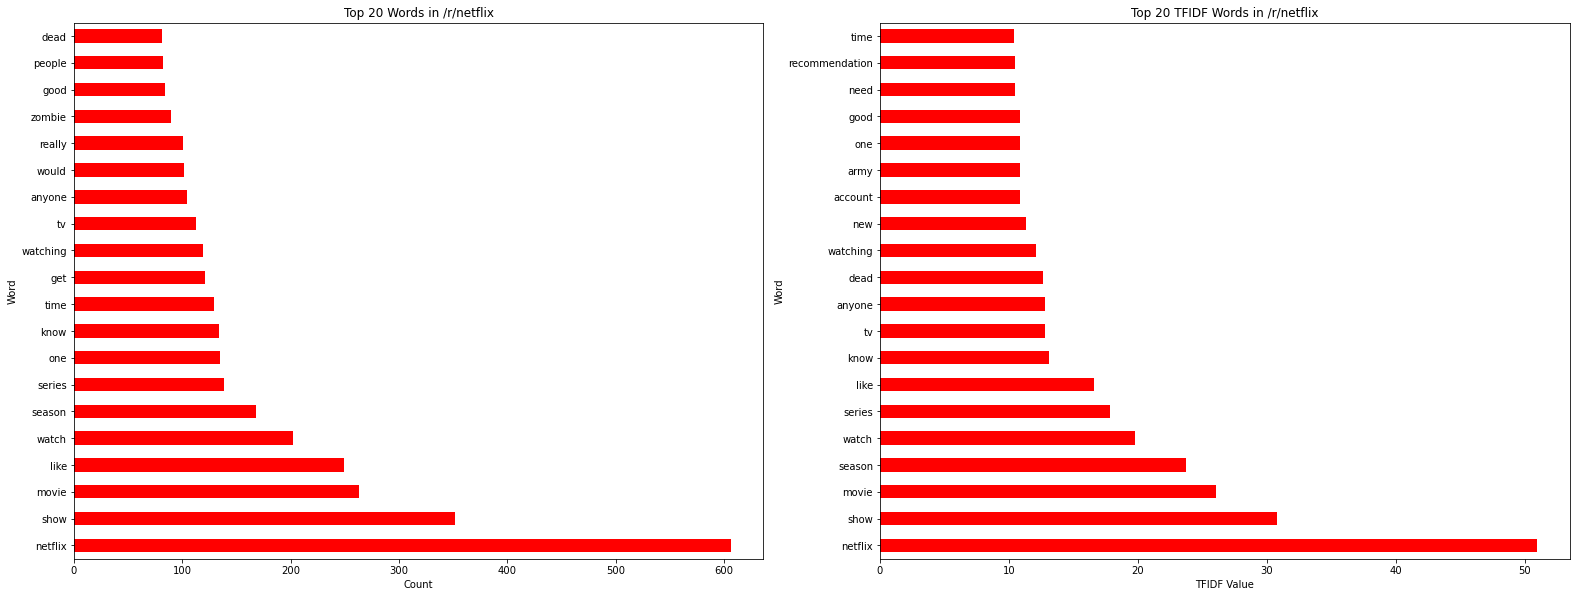

In [30]:
Xnflx = cvec.fit_transform(X_nflx)
X_netflix = tfidf.fit_transform(X_nflx)

X_nflx_df = pd.DataFrame(Xnflx.todense(), columns=cvec.get_feature_names())

X_netflix_df = pd.DataFrame(X_netflix.todense(), columns=tfidf.get_feature_names())


plt.figure(figsize = (22,16), facecolor = 'white')

# plotting top 20 occuring words
plt.subplot(2,2,1)
X_nflx_df.sum().sort_values(ascending = False).head(20).plot(kind = 'barh', color = 'red')
plt.title('Top 20 Words in /r/netflix')
plt.xlabel('Count')
plt.ylabel('Word')

# plotting top 20 occuring words
plt.subplot(2,2,2)
X_netflix_df.sum().sort_values(ascending = False).head(20).plot(kind = 'barh', color = 'red')
plt.title('Top 20 TFIDF Words in /r/netflix')
plt.xlabel('TFIDF Value')
plt.ylabel('Word')

plt.tight_layout()

Within the 20 most frequent words, the most that appeared the most are video streaming terms, such as 'netflix', 'show', 'movie', 'season', etc.

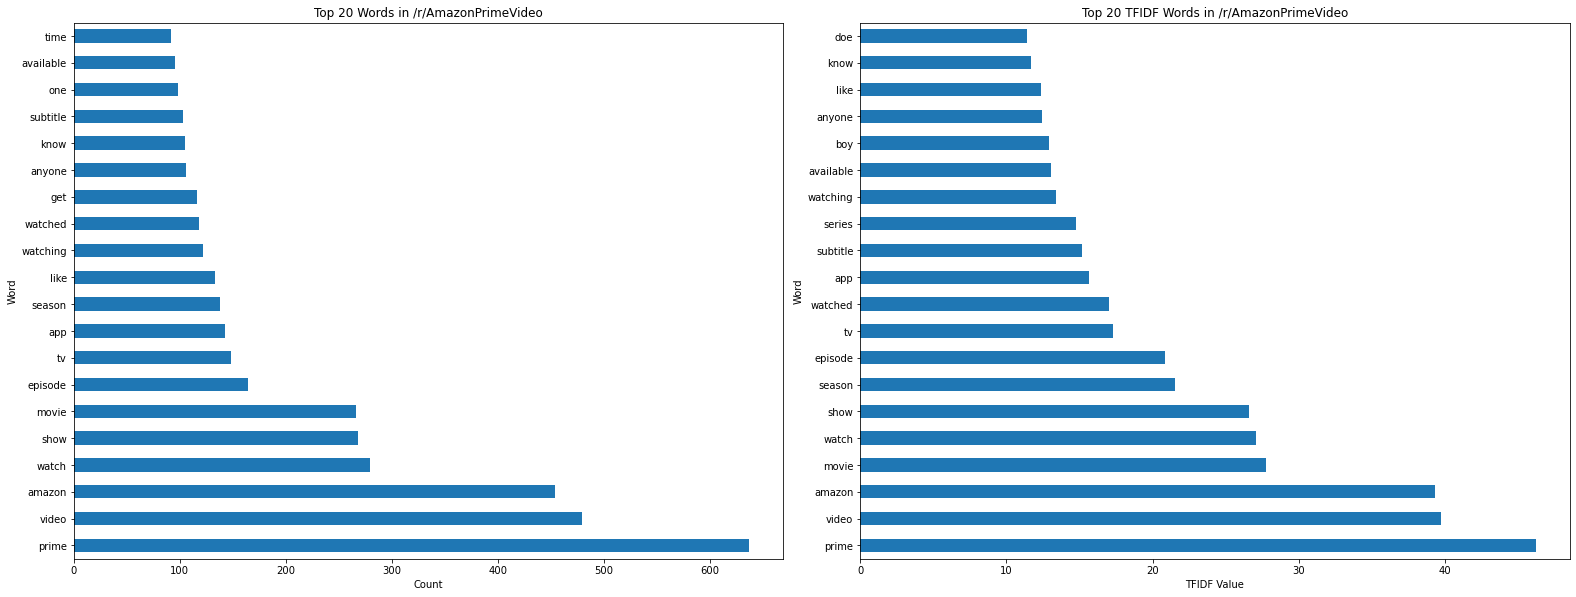

In [31]:
Xamzn = cvec.fit_transform(X_amzn)
X_amazon = tfidf.fit_transform(X_amzn)

X_amzn_df = pd.DataFrame(Xamzn.todense(), columns=cvec.get_feature_names())

X_amazon_df = pd.DataFrame(X_amazon.todense(), columns=tfidf.get_feature_names())


plt.figure(figsize = (22,16), facecolor = 'white')

# plotting top 20 occuring words
plt.subplot(2,2,1)
X_amzn_df.sum().sort_values(ascending = False).head(20).plot(kind = 'barh')
plt.title('Top 20 Words in /r/AmazonPrimeVideo')
plt.xlabel('Count')
plt.ylabel('Word')

# plotting top 20 occuring words
plt.subplot(2,2,2)
X_amazon_df.sum().sort_values(ascending = False).head(20).plot(kind = 'barh')
plt.title('Top 20 TFIDF Words in /r/AmazonPrimeVideo')
plt.xlabel('TFIDF Value')
plt.ylabel('Word')

plt.tight_layout()

Simimlarly to the previous plots for Netflix, the most occuring words within r/AmazonPrimeVideo are relevant to video streaming terms as well, outside of the common 'amazon' and 'prime', words like 'video', 'movie', 'watch', etc. appears a lot.

To take the analysis to a deeper level, the ngram_range for the vectorizers was increased to (2, 2) to reflect bigrams, which are two adjacent elements within a string of tokens in sequence.

In [32]:
cvec_2 = CountVectorizer(stop_words = stop_words, ngram_range = (2,2))
tfidf_2 = TfidfVectorizer(stop_words = stop_words, ngram_range = (2,2))

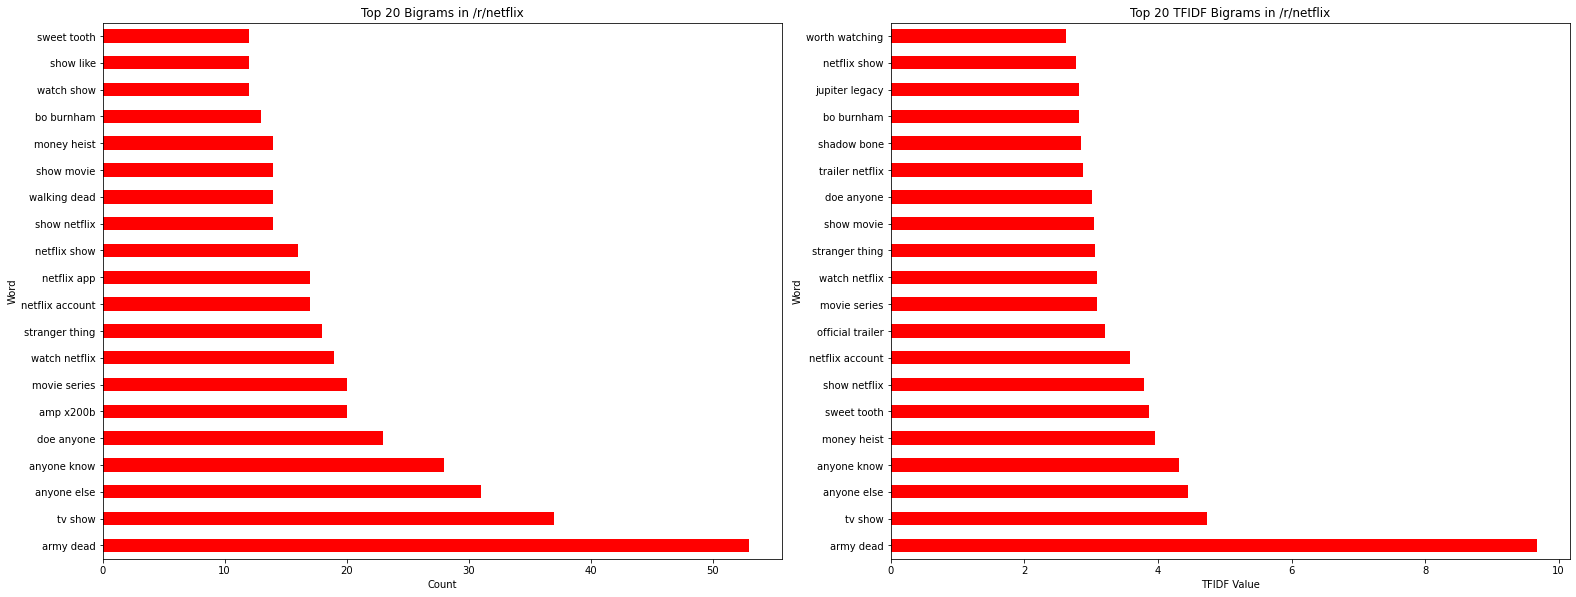

In [33]:
Xnflx2 = cvec_2.fit_transform(X_nflx)
X_netflix2 = tfidf_2.fit_transform(X_nflx)

X_nflx_df2 = pd.DataFrame(Xnflx2.todense(), columns=cvec_2.get_feature_names())

X_netflix_df2 = pd.DataFrame(X_netflix2.todense(), columns=tfidf_2.get_feature_names())


plt.figure(figsize = (22,16), facecolor = 'white')

# plotting top 20 occuring words
plt.subplot(2,2,1)
X_nflx_df2.sum().sort_values(ascending = False).head(20).plot(kind = 'barh', color = 'red')
plt.title('Top 20 Bigrams in /r/netflix')
plt.xlabel('Count')
plt.ylabel('Word')

# plotting top 20 occuring words
plt.subplot(2,2,2)
X_netflix_df2.sum().sort_values(ascending = False).head(20).plot(kind = 'barh', color = 'red')
plt.title('Top 20 TFIDF Bigrams in /r/netflix')
plt.xlabel('TFIDF Value')
plt.ylabel('Word')

plt.tight_layout()

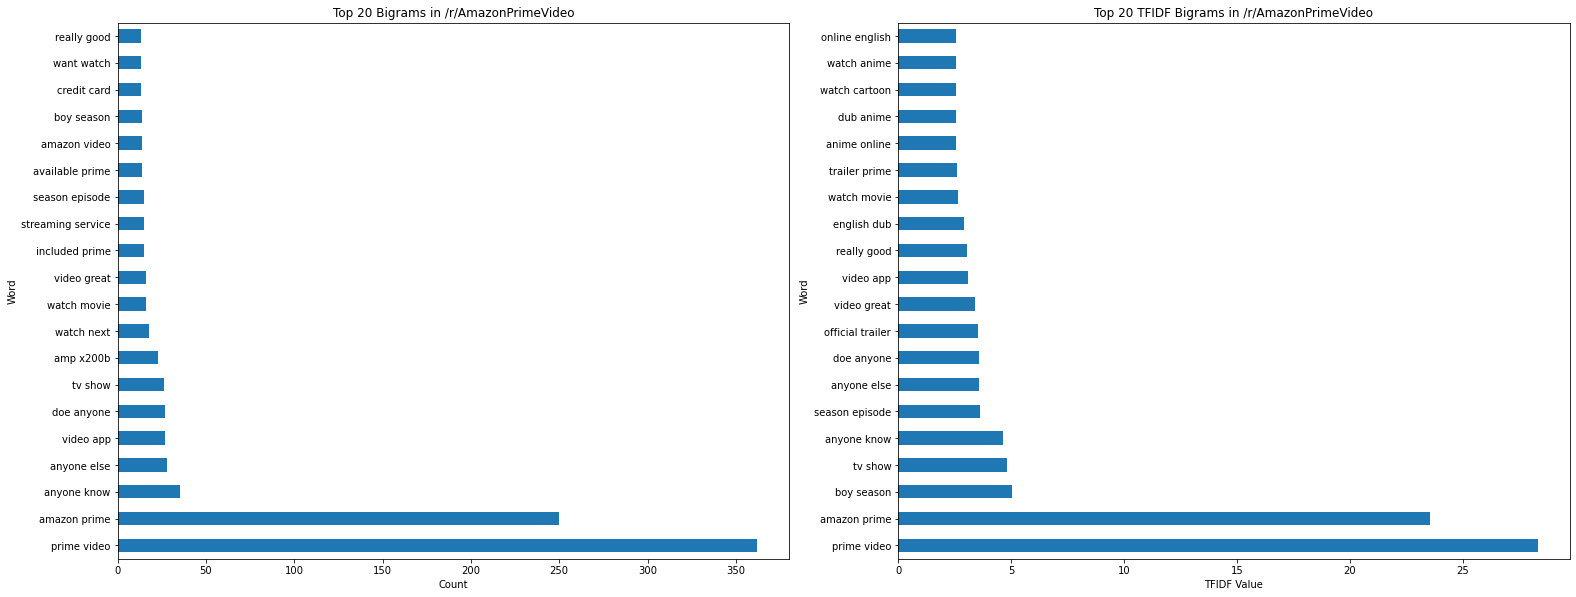

In [34]:
Xamzn2 = cvec_2.fit_transform(X_amzn)
X_amazon2 = tfidf_2.fit_transform(X_amzn)

X_amzn_df2 = pd.DataFrame(Xamzn2.todense(), columns=cvec_2.get_feature_names())

X_amazon_df2 = pd.DataFrame(X_amazon2.todense(), columns=tfidf_2.get_feature_names())


plt.figure(figsize = (22,16), facecolor = 'white')

# plotting top 20 occuring words
plt.subplot(2,2,1)
X_amzn_df2.sum().sort_values(ascending = False).head(20).plot(kind = 'barh')
plt.title('Top 20 Bigrams in /r/AmazonPrimeVideo')
plt.xlabel('Count')
plt.ylabel('Word')

# plotting top 20 occuring words
plt.subplot(2,2,2)
X_amazon_df2.sum().sort_values(ascending = False).head(20).plot(kind = 'barh')
plt.title('Top 20 TFIDF Bigrams in /r/AmazonPrimeVideo')
plt.xlabel('TFIDF Value')
plt.ylabel('Word')

plt.tight_layout()

By changing the vectorizer to only identify bigrams, it can be observed that there are multiple names of shows that occur frequently within r/Netflix, and they happen to be original shows produced by Netflix. This trend is observed as most of the submissions pulled from the subreddit is relatively recent, and most of these shows have only recently been released.

On the other hand, the plots from r/AmazonPrimeVideo does not display as many original show names, and the most frequently seen bigrams are 'prime video' and 'amazon prime' when the dataset ran through both the CountVectorizer and TFIDFVectorizer. The only notable bigram that could be relevant to a show would be 'boy season', which is most likely reflecting the show 'The Boys'.

In [35]:
X = subreddits['info']
y = subreddits['subreddit']

### Baseline Accuracy

In [36]:
y.value_counts(normalize = True)

1    0.507772
0    0.492228
Name: subreddit, dtype: float64

The baseline accuracy to predict whether a post is within r/Netflix is approximately 0.51.

# Preprocessing & Modeling

In [37]:
# Splitting data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    random_state = 42,
                                                    stratify=y)

In [38]:
# A pipeline is used to instantiate the vectorizers and models
pipe = Pipeline([("vec", None), ("model", None)])

# Parameter grid to set up hyperparameters of the individual vectorizers and models to determine their performance
param_grid = [{"vec": [CountVectorizer(), TfidfVectorizer()], 
               "vec__stop_words" : [None, stop_words],
               "vec__ngram_range" : [(1,1), (1,2), (1, 3), (2, 2)], 
               "model" : [RandomForestClassifier()], 
               "model__n_estimators" : [5, 10, 15],
               "model__max_depth" : [6, 7, 8],
               "model__min_samples_split" : [2, 3]},
              {"vec": [CountVectorizer(), TfidfVectorizer()],
               "vec__stop_words" : [None, stop_words],
               "vec__ngram_range" : [(1,1), (1,2), (1,3), (2, 2)],
               "model": [MultinomialNB()],
               "model__alpha" : [1.0, 2.0, 3.0, 4.0, 5.0]}
             ]

# Instantiate the GridSearch with the pipeline and param_grid arguments determined above
gs = GridSearchCV(pipe, param_grid, cv = 5, scoring = 'accuracy')

# Fit GridSearch to training dataset
gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('vec', None), ('model', None)]),
             param_grid=[{'model': [RandomForestClassifier()],
                          'model__max_depth': [6, 7, 8],
                          'model__min_samples_split': [2, 3],
                          'model__n_estimators': [5, 10, 15],
                          'vec': [CountVectorizer(), TfidfVectorizer()],
                          'vec__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2)],
                          'vec__stop_words': [None,
                                              ['i', 'me', 'my', 'myself'...
                                                              'itself', ...]),
                                  TfidfVectorizer()],
                          'vec__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2)],
                          'vec__stop_words': [None,
                                              ['i', 'me', 'my', 'myself', 'we',
                                               'our

In [39]:
train_score = gs.best_score_
test_score = gs.score(X_test, y_test)

In [40]:
print(f'Training score: {train_score}')
print(f'Test score: {test_score}')

if train_score - test_score < 0.1:
    print ('This is a good fit.')

Training score: 0.8321690461225344
Test score: 0.82574568288854
This is a good fit.


In [41]:
pd.DataFrame(gs.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__max_depth,param_model__min_samples_split,param_model__n_estimators,param_vec,param_vec__ngram_range,...,param_model__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
339,0.059787,0.001217,0.008712,0.000666,MultinomialNB(alpha=4.0),NaN,NaN,NaN,"CountVectorizer(ngram_range=(1, 2),\n ...","(1, 2)",...,4,"{'model': MultinomialNB(alpha=4.0), 'model__al...",0.818533,0.833977,0.849421,0.825581,0.833333,0.832169,0.010311,1
323,0.059848,0.001180,0.008734,0.000687,MultinomialNB(alpha=4.0),NaN,NaN,NaN,"CountVectorizer(ngram_range=(1, 2),\n ...","(1, 2)",...,3,"{'model': MultinomialNB(alpha=4.0), 'model__al...",0.818533,0.830116,0.849421,0.821705,0.833333,0.830622,0.010832,2
357,0.094290,0.002095,0.011528,0.000843,MultinomialNB(alpha=4.0),NaN,NaN,NaN,"CountVectorizer(ngram_range=(1, 2),\n ...","(1, 3)",...,5,"{'model': MultinomialNB(alpha=4.0), 'model__al...",0.818533,0.830116,0.837838,0.825581,0.837209,0.829855,0.007271,3
307,0.059757,0.001174,0.008698,0.000645,MultinomialNB(alpha=4.0),NaN,NaN,NaN,"CountVectorizer(ngram_range=(1, 2),\n ...","(1, 2)",...,2,"{'model': MultinomialNB(alpha=4.0), 'model__al...",0.810811,0.810811,0.864865,0.821705,0.837209,0.829080,0.020340,4
355,0.059782,0.001284,0.008725,0.000661,MultinomialNB(alpha=4.0),NaN,NaN,NaN,"CountVectorizer(ngram_range=(1, 2),\n ...","(1, 2)",...,5,"{'model': MultinomialNB(alpha=4.0), 'model__al...",0.818533,0.822394,0.845560,0.825581,0.833333,0.829080,0.009569,5


In [42]:
gs.best_params_

{'model': MultinomialNB(alpha=4.0),
 'model__alpha': 4.0,
 'vec': CountVectorizer(ngram_range=(1, 2),
                 stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                             'ourselves', 'you', "you're", "you've", "you'll",
                             "you'd", 'your', 'yours', 'yourself', 'yourselves',
                             'he', 'him', 'his', 'himself', 'she', "she's",
                             'her', 'hers', 'herself', 'it', "it's", 'its',
                             'itself', ...]),
 'vec__ngram_range': (1, 2),
 'vec__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  

Based on the GridSearch method, it can be determined that the best combination of transformers, models, and hyperparameters is the CountVectorizer with the ngram_range of (1,2) and english stop words removed, used with the Multinomial Naive Bayes model on a smoothing parameter (alpha) of 4.0.

# Model Evaluation

In [43]:
y_pred = gs.predict(X_test)

In [44]:
df = pd.DataFrame(confusion_matrix(y_test, y_pred),
                  columns=['r/Netflix', 'r/AmazonPrimeVideo'],
                  index=['r/Netflix', 'r/AmazonPrimeVideo'])

Text(50.99999999999999, 0.5, 'Actual')

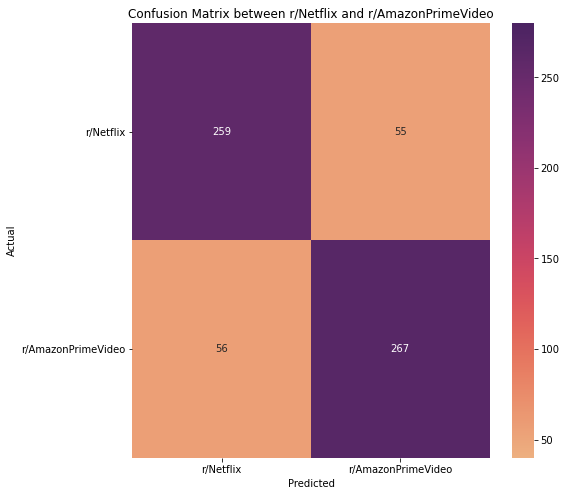

In [45]:
plt.figure(figsize = (8,8))
sns.heatmap(df, annot = True, vmin = 40, vmax = 280, fmt = '.0f', cmap = 'flare')
plt.tick_params(axis = 'y', labelrotation = 360.0)
plt.title('Confusion Matrix between r/Netflix and r/AmazonPrimeVideo')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [46]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f'The model was able to correctly predict {round((tp+tn)/(tp+fp+tn+fn),3) * 100}% of the observations.')
print(f'Misclassification rate: {round((fp+fn)/(tp+fp+tn+fn),3) * 100}%')
print(f'Among posts that the model predicted to be in r/Netflix, {round(tp/(tp+fp),2) * 100}% of them were correctly classified.')
print(f'Among posts that are in r/Netflix, the model has {round(tp/(tp+fn),2) * 100}% of them correctly classified.')
print(f'Among posts that are in r/AmazonPrimeVideo, the model has {round(tn/(tn+fp),2) * 100}% of them classified correctly.')

The model was able to correctly predict 82.6% of the observations.
Misclassification rate: 17.4%
Among posts that the model predicted to be in r/Netflix, 83.0% of them were correctly classified.
Among posts that are in r/Netflix, the model has 83.0% of them correctly classified.
Among posts that are in r/AmazonPrimeVideo, the model has 82.0% of them classified correctly.


## Limitations

In [47]:
df_pred = pd.DataFrame({
    'X_test': X_test,
    'y_test': y_test,
    'y_pred': y_pred
})

In [48]:
# Posts incorrectly predicted to be in r/Netflix

for i in df_pred[(df_pred.y_test - df_pred.y_pred) > 0]['X_test']:
    print(i)
    print('-'*10)

 did anybody else just miss the end of the niner s cardinal s game it went to commercial when kyle went down and then came back straight into the post game intro am i unlucky or is this why everyone pay for nfl channel 
----------
 why bother adding the series being human if you won t add all the episode 
----------
 what happened to mtv hit 
----------
 help why is it not playing in hd 
----------
 how to block certain show i haven t found any information on how to help with this my baby brother ha gotten addicted to one of those weird budget animated youtube kid show and i want to block it so it can t be viewed on the account i hate that those show are on there so how i can i restrict the viewing of individual show 
----------
 pyaasa the thirsty one the very definition of perfect cinema do watch 
----------
 the wild had no criticism and this is bad we live in the day and age of echo chamber all the major medium outlet are celebrating the show a the better version of lost due to ama

In [49]:
# Posts incorrectly predicted to be in r/AmazonPrimeVideo

for i in df_pred[(df_pred.y_test - df_pred.y_pred) < 0]['X_test']:
    print(i)
    print('-'*10)

 any news on more episode of these show 
----------
 hello 
----------
 who saw dirty john betty broderick christian slater play such a great scumbag lawyer just watching the betty broderick season of dirty john it s disturbing what an asshole christian slater character is and how he play an asshole so well it s gonna take me a while before i can see him a anything but an asshole 
----------
 these amazing necklace are free for a limited time check them out 
----------
 joe exotics legalfund just launched tking token 
----------
 same footage i don t know where else to put this but they used the exact same interview footage in the night stalker and zodiac killer from the latino homicide detective the same video footage for two different killer committing crime a decade apart 
----------
 anyone heard about 12 monkey 
----------
 doe the account that ha my profile get notified when i log in or anything else like a mail 
----------
 remind me feature not working so i usually add a bunch 

Based on the observations above, we can see that the misclassified posts have very generalised uses of words and terms, which could throw off the model as these posts do not have clear signs that they fall within either subreddits. There are also a post with the word 'netflix' but was misclassified within r/AmazonPrimeVideo. 

Some identifiable outliers within this dataset would be the shows that are part of both streaming platforms and are mentioned in both subreddits, or a post within r/AmazonPrimeVideo that compares between the various video streaming services (Netflix, AmazonPrimeVideo, Hulu, Disney+). This could cause a slight miscalculation by the model if the word 'netflix' is given enough importance that would cause it to be predicted to fall within r/Netflix. However, given the size of the pulled dataset and low likelihood of a similar scenario occurring, it can be overlooked for this project.

# Conclusions & Recommendations

The Multinomial Naive Bayes classifier performed well with a test accuracy score of 82.6%. This is within expectations because the topics of our two chosen subreddits are relatively similar. As such, a Subreddit Classifier web application can be developed, where users can submit their draft post in the application to determine which of the two subreddits would be the most suitable for the post for a potential use case.

Scope for future improvements:
- Optimize stop words and explore strategies for stemming and lemmatization
- Run the model through more historical and live updated data, since the subreddits are constanly being updated with new submissions
- Ability for model to classify more than two subreddits